# Statement

A companhia de seguros Proteja Seu Amanhã quer resolver algumas tarefas com a ajuda de aprendizado de máquina e você precisa avaliar a possibilidade de fazê-lo.

- Tarefa 1: Encontrar clientes semelhantes a um determinado cliente. Isso vai ajudar os agentes da empresa com tarefas de marketing.
- Tarefa 2: Predizer se um novo cliente provavelmente receberá um pagamento de seguro. Um modelo de predição pode ser melhor do que um modelo dummy?
- Tarefa 3: Predizer o número de pagamentos de seguro que um novo cliente provavelmente receberá usando um modelo de regressão linear.
- Tarefa 4: Proteger os dados pessoais dos clientes sem estragar o modelo da tarefa anterior. É necessário desenvolver um algoritmo de transformação de dados que tornaria difícil recuperar informações pessoais se os dados caíssem nas mãos erradas. Isso é chamado de mascaramento de dados ou ofuscação de dados. Mas os dados devem ser protegidos de forma que a qualidade dos modelos de aprendizado de máquina não piore. Você não precisa escolher o melhor modelo, só prove que o algoritmo funciona corretamente.

# Pré-processamento de dados & Exploração

## Inicialização

In [7]:
!pip install scikit-learn --upgrade --user


[notice] A new release of pip is available: 24.1 -> 24.1.2
[notice] To update, run: C:\Users\renan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import math

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from IPython.display import display

## Carregar Dados

Carregue os dados e faça uma verificação básica de que estão livres de problemas óbvios.

In [9]:
df = pd.read_csv('./datasets/insurance_us.csv')

Renomeamos as colunas para tornar o código mais consistente com seu estilo.

In [10]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [11]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4532,0,30.0,40400.0,0,0
217,1,29.0,45600.0,1,0
1589,1,35.0,23000.0,1,0
2299,0,44.0,24600.0,3,1
1648,0,18.0,36800.0,1,0
4305,1,41.0,46500.0,1,0
4472,0,25.0,43000.0,5,0
2551,1,33.0,33400.0,1,0
3973,0,27.0,29400.0,1,0
2353,0,19.0,51000.0,0,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [13]:
#corrigindo o tipo de dados de idade (de float para int)
df['age'] = df['age'].astype('int')

In [14]:
# verificando se a conversão foi bem-sucedida
print(df.dtypes)

gender                  int64
age                     int32
income                float64
family_members          int64
insurance_benefits      int64
dtype: object


In [15]:
#Avaliando as estatísticas descritivas dos dados.
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


* A coluna 'gender' apresenta uma média de 0.499, indicando que a população está dividida praticamente na sua metade em relação aos gêneros;


* A coluna 'age' nos mostra uma grande variação nas idades, de 18 até 65 anos. Porém, 75% dos clientes tem até 37 anos;


* A coluna 'income' nos mostra uma variação muito grande nos salários, indo de 5300 à 79000. Porém, apenas 25% dos clientes ganham menos que 33300;


* A coluna 'family_members' apresenta o mínimo de 0, mas não é possível que uma família tenha 0 membros, então vamos considerar que a coluna se refere a membros familiares além do próprio segurado;


* A coluna 'ensurance_benefits' nos mostra que o cliente que mais recebeu benefícios do seguro, recebeu um total de 5 benefícios, o que é muito se comparado ao geral, pois mais de 75% dos clientes não recebeu benefício algum.

## AED

Vamos verificar rapidamente se existem determinados grupos de clientes observando o gráfico de pares.

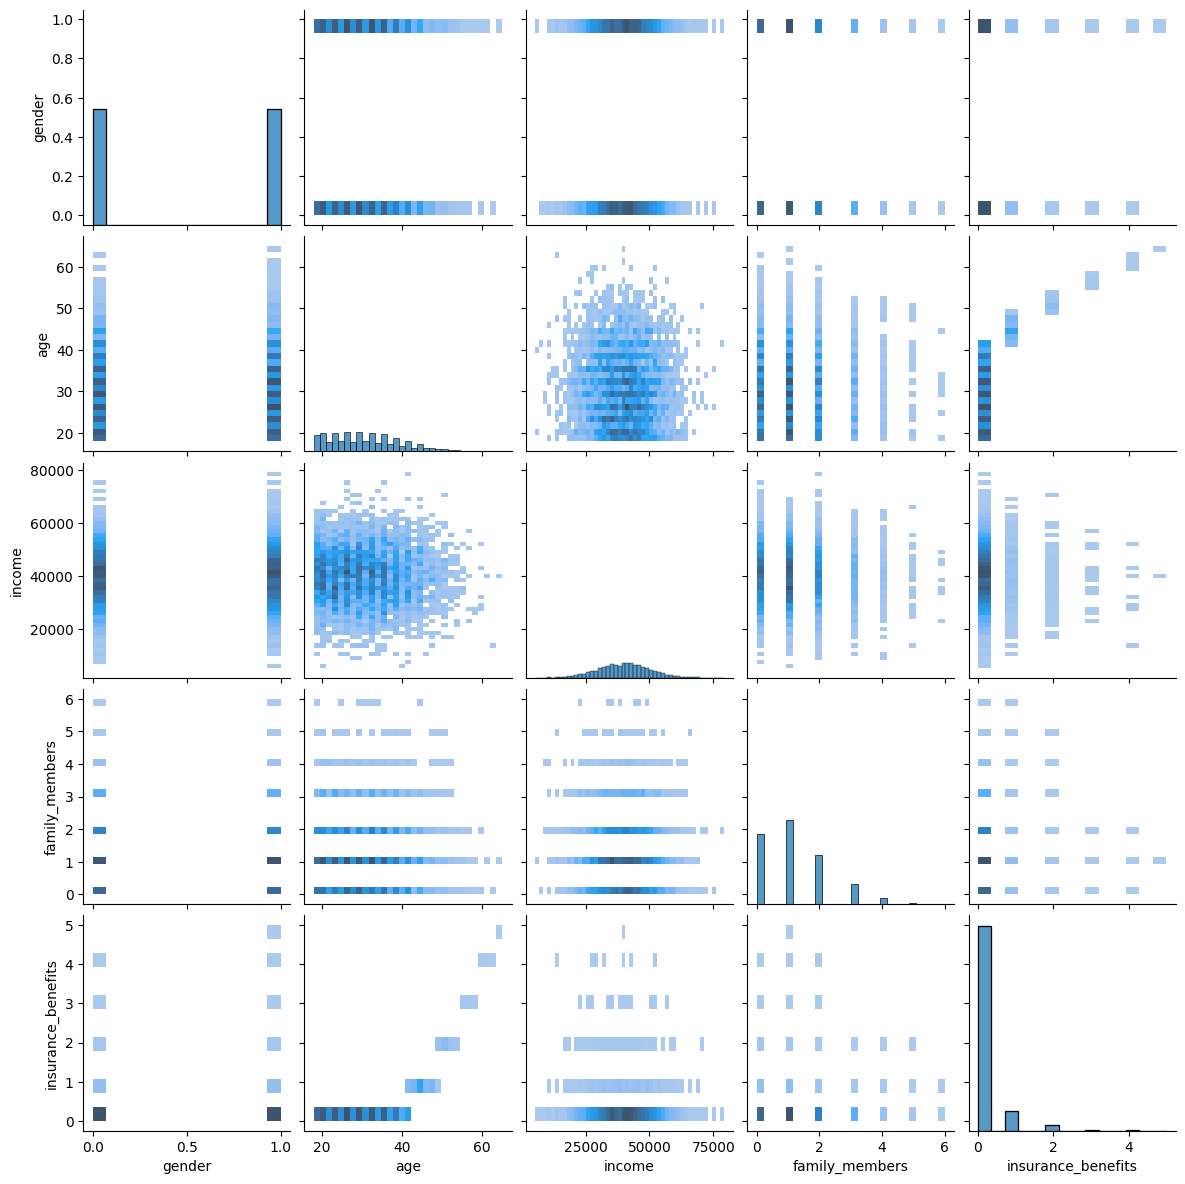

In [16]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

É um pouco difícil identificar grupos óbvios (clusters), pois é difícil combinar várias variáveis simultaneamente (para analisar distribuições multivariadas). É aí que Álgebra Linear e Aprendizado de Máquina podem ser bastante úteis.

# Tarefa 1. Clientes Similares

Na linguagem de AM, é necessário desenvolver um procedimento que retorne k vizinhos mais próximos (objetos) para um determinado objeto com base na distância entre os objetos.
Você pode querer rever as seguintes lições (capítulo -> lição)
- Distância Entre Vetores -> Distância Euclidiana
- Distância Entre Vetores -> Distância de Manhattan

Para resolver a tarefa, podemos tentar diferentes métricas de distância.

Escreva uma função que retorne k vizinhos mais próximos para um n-ésimo objeto com base em uma métrica de distância especificada. O número de pagamentos de seguro recebidos não deve ser levado em consideração para esta tarefa. 

Você pode usar uma implementação pronta do algoritmo kNN do scikit-learn (verifique [o link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) ou usar a sua própria.
Teste-o para quatro combinações de dois casos
- Escalabilidade
  - os dados não são escalados
  - os dados escalados com o escalonador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) 
- Métricas de distância
  - Euclidiana
  - Manhattan

Responda às perguntas:
- Os dados não escalados afetam o algoritmo kNN? Se sim, como isso acontece?
-Quão semelhantes são os resultados usando a métrica de distância de Manhattan (independentemente da escalabilidade)?

In [17]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [18]:
def get_knn(df, n, k, metric):
    
    """
    Retorna os vizinhos mais próximos de k

    :param df: DataFrame pandas usado para encontrar objetos semelhantes dentro de
    :param n: número do objeto pelo qual os vizinhos mais próximos são procurados
    :param k: o número dos vizinhos mais próximos a serem retornados
    :param metric: nome da métrica de distância    """

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors = k, metric = metric)
    nbrs.fit(df[feature_names])
    
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res


Escalando os dados

In [19]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

C:\Users\renan\AppData\Local\Temp\ipykernel_6996\760832288.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.63076923 0.70769231 0.44615385 ... 0.30769231 0.33846154 0.43076923]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())
C:\Users\renan\AppData\Local\Temp\ipykernel_6996\760832288.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.16666667 0.16666667 0.         ... 0.33333333 0.5        0.16666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())


In [20]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
3554,0,0.446154,0.546835,0.000000,0
4192,0,0.338462,0.705063,0.000000,0
4423,1,0.415385,0.586076,0.000000,0
1034,0,0.384615,0.244304,0.500000,0
2642,1,0.553846,0.462025,0.333333,0


Agora, vamos obter registros semelhantes para um determinado registro para cada combinação

In [21]:
#df e euclidean
df_euclidean = get_knn(df, 0, 5, 'euclidean')

df_euclidean

C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.000000
2022,1,41,49600.0,0,0,1.000000
1225,0,42,49600.0,0,1,1.732051
4031,1,44,49600.0,2,1,3.162278
3424,0,38,49600.0,0,0,3.316625


In [22]:
#df_scaled e euclidian
df_scaled_euclidean = get_knn(df_scaled, 0, 5, 'euclidean')

df_scaled_euclidean

C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,0.630769,0.627848,0.166667,0,0.000000
2689,1,0.630769,0.634177,0.166667,0,0.006329
133,1,0.615385,0.636709,0.166667,0,0.017754
4869,1,0.646154,0.637975,0.166667,1,0.018418
3275,1,0.646154,0.651899,0.166667,1,0.028550


In [23]:
#df e manhattan
df_manhattan = get_knn(df, 0, 5, 'manhattan')

df_manhattan

C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.0
2022,1,41,49600.0,0,0,1.0
1225,0,42,49600.0,0,1,3.0
4031,1,44,49600.0,2,1,4.0
815,1,37,49600.0,2,0,5.0


In [24]:
#df_scaled e manhattan
df_scaled_manhattan = get_knn(df_scaled, 0, 5, 'manhattan')

df_scaled_manhattan

C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,0.630769,0.627848,0.166667,0,0.000000
2689,1,0.630769,0.634177,0.166667,0,0.006329
133,1,0.615385,0.636709,0.166667,0,0.024245
4869,1,0.646154,0.637975,0.166667,1,0.025511
2103,1,0.630769,0.596203,0.166667,0,0.031646


In [25]:
# Concatenar os DataFrames para apresentar os resultados de menores distâncias de forma compilada
df_concat_distances = pd.concat(
    [df_euclidean['distance'].reset_index(drop=True),
     df_scaled_euclidean['distance'].reset_index(drop=True),
    df_manhattan['distance'].reset_index(drop=True),
    df_scaled_manhattan['distance'].reset_index(drop=True)],
    axis='columns', ignore_index=True)

df_concat_distances.columns = ['df_euclidean', 'df_scaled_euclidean', 'df_manhattan', 'df_scaled_manhattan']

print('As menores distâncias em cada DataFrame:')
df_concat_distances

As menores distâncias em cada DataFrame:


,df_euclidean,df_scaled_euclidean,df_manhattan,df_scaled_manhattan
0,0.000000,0.000000,0.0,0.000000
1,1.000000,0.006329,1.0,0.006329
2,1.732051,0.017754,3.0,0.024245
3,3.162278,0.018418,4.0,0.025511
4,3.316625,0.028550,5.0,0.031646


Respostas para as perguntas

**Os dados não escalados afetam o algoritmo kNN? Se sim, como isso acontece?** 

Sim. Quando os dados não são previamente escalados, as distâncias são muito maiores. 
Isso se dá porque os dados não escalados podem ter características distintas em diferentes escalas, o que pode impactar a métrica de distância no KNN. No nosso caso específico, isso se dá principalmente pela característica 'income' que possui valores muito altos se comparados aos valores das demais características.

**Quão semelhantes são os resultados usando a métrica de distância de Manhattan (independentemente da escalabilidade)?** 

As distâncias quando utilizada a métrica da distância de Manhattan são sempre um número inteiro.
Isso ocorre porque essa métrica é a soma das diferenças absolutas entre as coordenadas correspondentes dos pontos e, se as coordenadas são números inteiros, a diferença absoluta também sempre será um número inteiro.

# Tarefa 2. É provável que o cliente receba um pagamento do seguro?

Em termos de aprendizado de máquina, podemos olhar para isso como uma tarefa de classificação binária.

Com os pagamentos de seguro sendo mais do que zero como objetivo, avalie se a abordagem da classificação kNN pode ser melhor do que um modelo dummy.

Instruções:
- Construa um classificador baseado em kNN e meça sua qualidade com a métrica F1 para k=1..10 tanto para os dados originais quanto para os escalados. Seria interessante ver como k pode influenciar a métrica de avaliação e se a escalabilidade dos dados faz alguma diferença. Você pode usar uma implementação pronta do algoritmo de classificação kNN do scikit-learn (verifique [o link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) ou usar a sua própria.
- Construa o modelo dummy, que é aleatório para este caso. Deve retornar com alguma probabilidade o valor "1". LVamos testar o modelo com quatro valores de probabilidade: 0, a probabilidade de fazer qualquer pagamento de seguro, 0,5, 1.

Divida os dados inteiros na proporção 70:30 para as partes de treinamento/teste.

In [26]:
# calcule a meta
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype('int')

# Dividir os dados em treinamento e teste
feature_names = ['gender', 'age', 'income', 'family_members']
target_name = 'insurance_benefits_received'

X_train, X_test, y_train, y_test = train_test_split(df[feature_names], df[target_name], test_size=0.3, random_state=42)

# Escalar os dados usando MaxAbsScaler
X_train_scaled = transformer_mas.fit_transform(X_train)
X_test_scaled = transformer_mas.transform(X_test)


probability = df['insurance_benefits_received'].mean()
print(df[['insurance_benefits', 'insurance_benefits_received']].sample(10))
print()
print('A Probabilidade de receber um pagamento do seguro é:', probability)

      insurance_benefits  insurance_benefits_received
3135                   0                            0
556                    0                            0
1855                   2                            1
956                    0                            0
4376                   0                            0
17                     0                            0
3684                   0                            0
1090                   1                            1
766                    0                            0
3799                   0                            0

A Probabilidade de receber um pagamento do seguro é: 0.1128


In [27]:
# verifique o desequilíbrio de classe com value_counts()

df['insurance_benefits_received'].value_counts()

insurance_benefits_received
0    4436
1     564
Name: count, dtype: int64

**Conclusões:**

* **Desequilíbrio de Classes:**  

Podemos verificar um desequilíbrio de classes nos dados, pois 88.72% dos dados pertencem à classe '0' e apenas 11.28% dos dados são da classe '1', ou seja, apenas 11.28% dos clientes receberam benefícios do seguro, exatamente como avaliado anteriormente com a média.

In [28]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# se você tiver um problema com a linha a seguir, reinicie o kernel e execute o caderno novamente
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de Confusão')
    print(cm)
    
    return f1_score, cm
    

# Avaliar o classificador kNN
for k in range(1, 11):
    print(f'k = {k}')
    
    # Modelo com dados originais
    print('Dados Originais')
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    f1_orig, cm_orig = eval_classifier(y_test, y_pred)
    print()
    
    # Modelo com dados escalados
    print('Dados Escalados')
    knn_scaled = KNeighborsClassifier(n_neighbors=k)
    knn_scaled.fit(X_train_scaled, y_train)
    y_pred_scaled = knn_scaled.predict(X_test_scaled)
    f1_scaled, cm_scaled = eval_classifier(y_test, y_pred_scaled)
    print()
    print()

k = 1
Dados Originais
F1: 0.65
Matriz de Confusão
[[0.87466667 0.018     ]
 [0.04666667 0.06066667]]

Dados Escalados
F1: 0.93
Matriz de Confusão
[[0.888      0.00466667]
 [0.00933333 0.098     ]]


k = 2
Dados Originais
F1: 0.38
Matriz de Confusão
[[0.89066667 0.002     ]
 [0.082      0.02533333]]

Dados Escalados
F1: 0.91
Matriz de Confusão
[[0.89       0.00266667]
 [0.01466667 0.09266667]]


k = 3
Dados Originais
F1: 0.39
Matriz de Confusão
[[0.88266667 0.01      ]
 [0.07933333 0.028     ]]

Dados Escalados
F1: 0.94
Matriz de Confusão
[[0.88933333 0.00333333]
 [0.00866667 0.09866667]]


k = 4
Dados Originais
F1: 0.16
Matriz de Confusão
[[0.88933333 0.00333333]
 [0.098      0.00933333]]

Dados Escalados
F1: 0.92
Matriz de Confusão
[[0.89133333 0.00133333]
 [0.01466667 0.09266667]]


k = 5
Dados Originais
F1: 0.17
Matriz de Confusão
[[0.884      0.00866667]
 [0.09666667 0.01066667]]

Dados Escalados
F1: 0.95
Matriz de Confusão
[[0.89       0.00266667]
 [0.00866667 0.09866667]]


k = 6

**EXIBIÇÃO DOS RESULTADOS DO MODELO KNN:**


| k  | F1 Original | Matriz de Confusão Original (VN-FP-FN-VP) | F1 Escalado | Matriz de Confusão Escalado(VN-FP-FN-VP)|
|----|:-----------:|:------------------------------------------|:-----------:|:----------------------------------------|
| 1  | 0.65        | [[0.8747, 0.018], [0.0467, 0.0607]]       | 0.93        | [[0.888, 0.0047], [0.0093, 0.098]]      |
| 2  | 0.38        | [[0.8907, 0.002], [0.082, 0.0253]]        | 0.91        | [[0.89, 0.0027], [0.0147, 0.0927]]      |
| 3  | 0.39        | [[0.8833, 0.0093], [0.0793, 0.028]]       | 0.94        | [[0.8893, 0.0033], [0.0087, 0.0987]]    |
| 4  | 0.16        | [[0.8893, 0.0033], [0.098, 0.0093]]       | 0.92        | [[0.8913, 0.0013], [0.0147, 0.0927]]    |
| 5  | 0.17        | [[0.8833, 0.0093], [0.0967, 0.0107]]      | 0.95        | [[0.89, 0.0027], [0.0087, 0.0987]]      |
| 6  | 0.09        | [[0.892, 0.0007], [0.102, 0.0053]]        | 0.92        | [[0.8913, 0.0013], [0.0153, 0.092]]     |
| 7  | 0.12        | [[0.8913, 0.0013], [0.1007, 0.0067]]      | 0.93        | [[0.89, 0.0027], [0.0113, 0.096]]       |
| 8  | 0.02        | [[0.8927, 0], [0.106, 0.0013]]            | 0.92        | [[0.8927, 0], [0.0153, 0.092]]          |
| 9  | 0.04        | [[0.8927, 0], [0.1053, 0.002]]            | 0.93        | [[0.8913, 0.0013], [0.012, 0.0953]]     |
| 10 | 0.04        | [[0.8927, 0], [0.1053, 0.002]]            | 0.92        | [[0.892, 0.0007], [0.0153, 0.092]]      |


Podemos observar que com os dados escalados, os resultados de F1 obtidos foram muito melhores, sendo que dentre estes modelos, o que apresentou os melhores resultados foi o de 'k' = 5, pois obteve um F1 = 0.95.

In [29]:
# gerando saída de um modelo aleatório

def random_model_predict(P, size, seed=42):
    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [30]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'A probabilidade: {P:.2f}')
    y_pred_random = random_model_predict(P, size=len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_random)
    print()

A probabilidade: 0.00


F1: 0.00
Matriz de Confusão
[[0.8872 0.    ]
 [0.1128 0.    ]]

A probabilidade: 0.11
F1: 0.12
Matriz de Confusão
[[0.7914 0.0958]
 [0.0994 0.0134]]

A probabilidade: 0.50
F1: 0.20
Matriz de Confusão
[[0.456  0.4312]
 [0.053  0.0598]]

A probabilidade: 1.00
F1: 0.20
Matriz de Confusão
[[0.     0.8872]
 [0.     0.1128]]



**EXIBIÇÃO DOS RESULTADOS DO MODELO DUMMY:**

  
| Probabilidade |     F1     | Matriz de Confusão (VN-FP-FN-VP)   |
|:-------------:|:----------:|:-----------------------------------|
| 0.00          | 0.00       | [[0.8872 0.    ], [0.1128 0.    ]] |
| 0.11          | 0.12       | [[0.7914 0.0958], [0.0994 0.0134]] |
| 0.50          | 0.20       | [[0.456  0.4312], [0.053  0.0598]] |
| 1.00          | 0.20       | [[0.     0.8872], [0.     0.1128]] |


* **Matriz da Probabilidade = 0 e F1 = 0:**
Como era de se esperar, com todas as previsões sendo negativas, obtivemos 88.72% de Verdadeiros Negativos e 11.28% de Falsos Negativos, exatamente como a verificação de desequilíbrio de classes nos havia informado.


* **Matriz da Probabilidade = 0.11 e F1 = 0.12:**  
79% das previsões foram Verdadeiros Negativos, 10% de Falsos Negativos, 10% de Falsos Positivos e 1% de Verdadeiros Positivos.  

* **Matriz da Probabilidade = 0.50 e F1 = 0.20:**
46% de Verdadeiros Negativos, 5% de Falsos Negativos, 43% de Falsos Positivos e 6% de verdadeiros Positivos.

* **Matriz da Probabilidade = 1.00 e F1 = 0.20:**
Inversamente a matriz de probabilidade 0, agora com todas as previsões sendo positivas, obtivemos 0% de Verdadeiros Negativos, 0% de Falsos Negativos, 88.72% de Falsos Positivos e 11.28% de Verdadeiros Positivos

**CONCLUSÕES DA TAREFA:**

**Com os pagamentos de seguro sendo mais do que zero como objetivo, avalie se a abordagem da classificação kNN pode ser melhor do que um modelo dummy.**

Avaliando os resultados obtidos foi possível observar que o modelo knn, em geral, apresentou resultados muito melhores do que os obtidos com o modelo Dummy, pois com os dados escalados, nosso modelo knn obteve um F1 de 0.95, o que é um resultado muito positivo, enquanto que o melhor resultado de F1 obtido com o modelo Dummy foi de apenas 0.20.

# Tarefa 3. Regressão (com Regressão Linear)

Com os pagamentos de seguro como objetivo, avalie qual seria o REQM para um modelo de Regressão Linear.

Construa sua própria implementação de Regressão Linear. Para isso, lembre-se de como a solução da tarefa de regressão linear é formulada em termos de Álgebra linear. Verifique o REQM para os dados originais e os escalados. Você pode ver alguma diferença no REQM entre esses dois casos?

Vamos denotar
- $X$ — matriz de características, cada linha é um caso, cada coluna é uma característica, a primeira coluna consiste em unidades
- $y$ — objetivo (um vetor)
- $\hat{y}$ — objetivo estimado (um vetor)
- $w$ — vetor de peso

A tarefa de regressão linear na linguagem de matrizes pode ser formulada como
$$
y = Xw
$$

O objetivo do treinamento, então, é encontrar os $w$ que minimizaria a distância L2 (EQM) entre $Xw$ e $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que há uma solução analítica para a questão acima:

$$
w = (X^T X)^{-1} X^T y
$$

A fórmula acima pode ser usada para encontrar os pesos $w$ e o último pode ser usado para calcular valores preditos

$$
\hat{y} = X_{val}w
$$

Divida todos os dados na proporção 70:30 para as partes de treinamento/validação. Use a métrica REQM para a avaliação do modelo.

In [31]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
        
    
    def fit(self, X, y):
        
        # somando as unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        self.wo = self.weights[0]     
        
  
    def predict(self, X):
        # Adicionando a coluna de unidades (bias/intercepto)
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        # Calculando as previsões
        y_pred = X2.dot(self.weights)
        return y_pred

In [32]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'REQM: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')
    
    return rmse, r2_score

In [33]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# Dados Originais
print("Dados Originais:")

lr = MyLinearRegression()
lr.fit(X_train, y_train)
print('Pesos:', lr.weights)
print()

y_test_pred = lr.predict(X_test)
rmse_orig, r2_orig = eval_regressor(y_test, y_test_pred)
print()


# Dados Transformados
X_train_scaled = transformer_mas.fit_transform(X_train)
X_test_scaled = transformer_mas.transform(X_test)

print("Dados Escalados:")

lr_scaled = MyLinearRegression()
lr_scaled.fit(X_train_scaled, y_train)
print('Pesos:', lr_scaled.weights)
print()

y_test_pred_scaled = lr_scaled.predict(X_test_scaled)
rmse_scaled, r2_scaled = eval_regressor(y_test, y_test_pred_scaled)

Dados Originais:
Pesos: [-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]

REQM: 0.34
R2: 0.66

Dados Escalados:
Pesos: [-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]

REQM: 0.34
R2: 0.66


**CONCLUSÕES:**

**Verifique o REQM para os dados originais e os escalados. Você pode ver alguma diferença no REQM entre esses dois casos?**


**RESPOSTA:** 

Não. O REQM obtido foi o mesmo para os dados escalados e para os dados originais, o que nos demosntra que para um modelo de Regressão Linear, a transformação dos dados não afeta o resultado do REQM e R2, diferentemente do que foi observado com os modelos knn, que tiveram resultados bem alterados após transformação dos dados. 

# Tarefa 4. Ofuscando dados

É melhor ofuscar os dados multiplicando as características numéricas (lembre-se, elas podem ser vistos como a matriz $X$) por uma matriz invertível $P$. 

$$
X' = X \times P
$$

Tente fazer isso e verifique como os valores das características ficarão após a transformação. Aliás, a invertibilidade é importante aqui, portanto, certifique-se de que $P$ seja realmente invertível.

Você pode querer revisar a lição 'Matrizes e Operações com Matrizes -> Multiplicação de Matrizes' para relembrar a regra de multiplicação de matrizes e sua implementação com NumPy.

In [34]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [35]:
X = df_pn.to_numpy()
X

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

In [36]:
X.shape

(5000, 4)

Gerando uma matriz $P$ aleatória.

In [37]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

P

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

Verificando se a matriz $P$ é invertível

In [38]:
P_inv = np.linalg.inv(P)

P_inv

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

Você consegue adivinhar a idade ou a renda dos clientes após a transformação?

In [39]:
X_transf = np.dot(X, P)

print(X_transf.shape)
print()
print(X_transf)

(5000, 4)

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


**Após a transformação não é possível advinhar as informações dos clientes.**

Você pode recuperar os dados originais de $X′$ se souber $P$? Tente verificar isso com cálculos movendo $P$ do lado direito da fórmula acima para o esquerdo. As regras da multiplicação de matrizes são realmente úteis aqui

In [40]:
X_rec = np.dot(X_transf, P_inv)

print(X_rec)

[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 ...
 [-1.92837871e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04  3.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  4.06000000e+04  1.00000000e+00]]


Imprima todos os três casos para alguns clientes
- Os dados originais
- O transformado
- O invertido (recuperado)

In [41]:
print('Dados Originais:')
print(X[:, :])
print()

print('Dados Transformados:')
print(X_transf[:, :])
print()

print('Dados Recuperados:')
print(X_rec[:, :])

Dados Originais:
[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]

Dados Transformados:
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]

Dados Recuperados:
[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 ...
 [-1.92837871e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.2700000

Você provavelmente pode ver que alguns valores não são exatamente iguais aos dos dados originais. Qual pode ser a razão disso?

**RESPOSTA:**

A razão dos dados não serem exibidos exatamente iguais é por conta de arredondamentos durante as operações de transformação e recuperação. Cada multiplicação de matrizes tem um arredondamento. 

Nos dados originais, as informações que são exibidas como zero, após as transformações retornam como um número muito pequeno, que tende a zero, como por exemplo 0.000000000000447363596, mas não exatamente zero.

## Provas de que a ofuscação de dados pode funcionar com a Regressão Linear

A tarefa de regressão foi resolvida com regressão linear neste projeto. Sua próxima tarefa é provar analiticamente que o método de ofuscação fornecido não afetará a regressão linear em termos de valores preditos, ou seja, seus valores permanecerão os mesmos. Você acredita nisso? Bem, você não precisa acreditar, você deve provar isso!

Assim, os dados são ofuscados e há $X \ P$ em vez de apenas X agora. Consequentemente, existem outros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

Como  $w$ e $w_P$ seriam ligados se você simplificasse a fórmula para $w_P$ acima? 

Quais seriam os valores previstos com $w_P$? 

O que isso significa para a qualidade da regressão linear se você medir com REQM?

Verifique o Apêndice B Propriedades das Matrizes no final do caderno. Existem fórmulas úteis lá!

Nenhum código é necessário nesta seção, apenas explicação analítica!

**RESPOSTA:**

Temos que $w = (X^T X)^{-1} X^T y$,  e que $w_P = [(XP)^T XP]^{-1} (XP)^T y$


<br>


**Vamos simplificar a fórmula de $w_P$:**

$w_P = (P^{-1}(X^TX)^{-1}(P^T)^{-1})(X^T P^T y)$,  

<br>  
como $(P^T)^{-1} P^T = I$, então temos que: $w_P = P^{-1}(X^TX)^{-1}X^T y$  $\quad \Rightarrow \quad$ $w_P = P^{-1} w$,  
<br>  

Portanto, $w_P$ é a transformação de $w$ pela inversa de $P$  
<br>  
<br> 

**Em relação aos valores previstos com  $𝑤𝑃$**

$\hat{y} = (XP)w_P$,  como $w_P = P^{-1} w$ $\quad \Rightarrow \quad (XP)w P^-1 \quad \Rightarrow \quad X (PP^-1)w \quad \Rightarrow \quad X Iw \quad \Rightarrow \quad Xw$


Analisando a fórmula simplificada acima, podemos inferir que os valores previstos usando  $w$ e $w_P$ são os mesmos, pois $Xw = Xw$.

Isso significa que o resultado não é impactado em relação à qualidade da regressão linear se medir com REQM.

## Teste de regressão linear com ofuscação de dados

Agora, vamos provar que a Regressão Linear pode funcionar computacionalmente com a transformação de ofuscação escolhida.
Crie um procedimento ou uma classe que execute a Regressão Linear opcionalmente com a ofuscação. Você pode usar uma implementação pronta de Regressão Linear do scikit-learn ou sua própria.

Execute a Regressão Linear para os dados originais e os ofuscados, compare os valores previstos e os valores da métrica $R^2$ do REQM. Há alguma diferença?

**Procedimento**

- Crie uma matriz quadrada $P$ de números aleatórios.
- Verifique se é invertível. Caso contrário, repita o primeiro ponto até obtermos uma matriz invertível.
- <! seu comentário aqui!>
- Use $XP$ como a nova matriz de características

In [42]:
rng = np.random.default_rng(seed=12345)
P = rng.random(size=(X.shape[1], X.shape[1]))

P

array([[0.22733602, 0.31675834, 0.79736546, 0.67625467],
       [0.39110955, 0.33281393, 0.59830875, 0.18673419],
       [0.67275604, 0.94180287, 0.24824571, 0.94888115],
       [0.66723745, 0.09589794, 0.44183967, 0.88647992]])

In [43]:
P_inv = np.linalg.inv(P)

P_inv

array([[-1.97240014,  1.76004024, -0.08309671,  1.22285233],
       [ 0.14111106,  0.32873452,  1.02824721, -1.27752175],
       [ 0.8908452 ,  0.90302415, -0.59501472, -0.23290483],
       [ 1.02530945, -1.81039816,  0.24787878,  0.46192295]])

In [44]:
X_transf = np.dot(X, P)

print(X_transf.shape)
print()
print(X_transf)

(5000, 4)

[[33385.62984818 46727.48014471 12338.75730965 47073.72396713]
 [25583.38794934 35803.91421888  9461.30119825 36066.96002212]
 [14139.21910127 19787.51177458  5230.51096108 19931.91947988]
 ...
 [22815.58655801 31933.96520708  8428.37958035 32172.5786907 ]
 [22009.95609777 30804.88005289  8132.92054542 31035.85751146]
 [27325.74102789 38246.92777622 10096.76786418 38531.36605622]]


In [45]:
class TestLinearRegression:
    
    def __init__(self):
        
        self.weights = None
        
    
    def fit(self, X_transf, y):
        
        # somando as unidades
        X2 = np.append(np.ones([len(X_transf), 1]), X_transf, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        self.wo = self.weights[0]     
        
  
    def predict(self, X_transf):
        # Adicionando a coluna de unidades (bias/intercepto)
        X2 = np.append(np.ones([len(X_transf), 1]), X_transf, axis=1)
        # Calculando as previsões
        y_pred = X2.dot(self.weights)
        return y_pred

In [46]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'REQM: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')
    
    return rmse, r2_score

In [47]:
X_transf = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_transf_train, X_transf_test, y_train, y_test = train_test_split(X_transf, y, test_size=0.3, random_state=12345)


# Dados Originais
print("Dados Originais:")

lr = TestLinearRegression()
lr.fit(X_transf_train, y_train)

y_test_pred = lr.predict(X_transf_test)
print('Valores previstos:', y_test_pred[:5])
rmse_orig, r2_orig = eval_regressor(y_test, y_test_pred)
print()


# Dados Transformados
X_transf_train_scaled = transformer_mas.fit_transform(X_transf_train)
X_transf_test_scaled = transformer_mas.transform(X_transf_test)

print("Dados Escalados:")

lr_scaled = TestLinearRegression()
lr_scaled.fit(X_transf_train_scaled, y_train)

y_test_pred_scaled = lr_scaled.predict(X_transf_test_scaled)
print('Valores previstos:', y_test_pred_scaled[:5])
rmse_scaled, r2_scaled = eval_regressor(y_test, y_test_pred_scaled)

Dados Originais:
Valores previstos: [ 0.17926625  0.80931996  0.45614337 -0.23762191  0.4650019 ]
REQM: 0.34
R2: 0.66

Dados Escalados:
Valores previstos: [ 0.17926625  0.80931996  0.45614337 -0.23762191  0.4650019 ]
REQM: 0.34
R2: 0.66


**Conclusões:**

Os resultados foram exatamente iguais para os dados originais e para os dados transformados (ofuscação), comprovando que a transformação não afeta as predições de um modelo de Regressão Linear.

# Apêndices

## Apêndice A: Escrevendo Fórmulas em Notebooks Jupyter

Você pode escrever fórmulas em seu Jupyter Notebook em uma linguagem de marcação de texto fornecida por um sistema de publicação de alta qualidade chamado $\LaTeX$ (pronuncia-se "Lah-tech"), e elas se parecerão com fórmulas em livros didáticos.
Para colocar uma fórmula em um texto, coloque o cifrão ($) antes e depois do texto da fórmula, por exemplo $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Se uma fórmula deve estar em seu próprio parágrafo, coloque o cifrão duplo ($$) antes e depois do texto da fórmula, por exemplo

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

A linguagem de marcação do [LaTeX](https://en.wikipedia.org/wiki/LaTeX) é muito popular entre as pessoas que usam fórmulas em seus artigos, livros e textos. Pode ser complexo, mas o básico é fácil. Confira esta [folha de dicas](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) de duas páginas  para aprender a compor as fórmulas mais comuns.

## Apêndice B: Propriedades das Matrizes

Matrizes têm muitas propriedades em Álgebra Linear. Algumas delas estão listadas aqui, o que pode ajudar na prova analítica deste projeto.

**OBS: Excluí sem querer as células do final e perdi o apêndice. Caso possa incluir novamente, por favor.**

Obrigado.